(supervised:ann:cnn-keras)=
# CNNs with Keras

We aim to construct and train a CNN for object detection in images using Keras. The CNN shall decide whether there is a cat or a dog in the image presented to the net. Training data for such tasks can be scraped from the web. But nowadays there are lots of image data bases holding additional information like labels for the images. We use a set of 25000 cat/dog images published under [CC0](https://creativecommons.org/publicdomain/zero/1.0/) for competition on [www.kaggle.com](https://www.kaggle.com/tongpython/cat-and-dog). Next to 25000 labeled (cat or dog) images for training the data set contains 12500 unlabeled images of cats and dogs.

```{figure} xkcd1425.png
---
alt: line drawing showing two people talking while one of them works at a computer
---
In the 60s, Marvin Minsky assigned a couple of undergrads to spend the summer programming a computer to use a camera to identify objects in a scene. He figured they'd have the problem solved by the end of the summer. Half a century later, we're still working on it. Source: Randall Munroe, [xkcd.com/1425](https://xkcd.com/1425)
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

data_path = '/home/jef19jdw/myfiles/datasets_teaching/ds2/catsdogs/data/'

2023-07-03 05:33:58.382411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# workarounds for some problems with Tensorflow (only use if neccessary)

import tensorflow as tf
import os

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/usr/lib/cuda'

2023-07-03 05:34:00.580105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 05:34:00.626591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 05:34:00.627646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Loading and Preprocessing Images

Keras supports loading images and labels from directories step by step during training without holding the whole data set in memory. Each class (cat or dog) has to have its own subdirectory. To use this feature we have to call [`keras.preprocessing.image_dataset_from_directory`](https://keras.io/api/preprocessing/image/), which returns a Tensorflow [`Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object. That object is an iterator yielding batches of images and corresponding labels.

We use 15000 images for training, 5000 for validation, and 5000 for testing.

Next to loading images from disk `image_dataset_from_directory` may apply simple preprocessing steps. Since all the images have different sizes we have to resize them.

In [3]:
img_size = 128    # width and height of images

train_data = keras.preprocessing.image_dataset_from_directory(
    data_path + 'labeled/train',
    label_mode = 'categorical',    # one-hot encoding with two columns
    image_size=(img_size, img_size),
    validation_split=0.25,
    subset='training',
    seed=0
)
val_data = keras.preprocessing.image_dataset_from_directory(
    data_path + 'labeled/train',
    label_mode = 'categorical',
    image_size=(img_size, img_size),
    validation_split=0.25,
    subset='validation',
    seed=0    # same seed as for training
)
test_data = keras.preprocessing.image_dataset_from_directory(
    data_path + 'labeled/test',
    label_mode = 'categorical',
    image_size=(img_size, img_size),
)

Found 20000 files belonging to 2 classes.
Using 15000 files for training.


2023-07-03 05:34:01.436610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 05:34:01.437382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 05:34:01.438385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-03 05:34:01.438842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

Found 20000 files belonging to 2 classes.
Using 5000 files for validation.
Found 5000 files belonging to 2 classes.


Note that resizing a non-square image to a square image distorts its content. Alternatively we could crop the longer side or fill the shorter with some color. Experiments have shown that distortions from resizing have no substantial influence on the prediction accuracy of the ANN trained with distorted images.

Each iterate generated by one of the data iterators is a tuple containing two NumPy arrays. The first array is a batch of images, the second contains the one-hot encoded labels.

To get an iterate we call Python's built-in functions `iter` and `next` (a TensorFlow `Dataset` object is an iterable object, which becomes an iterator via `iter`).

In [4]:
images, labels = next(iter(train_data))
images.shape, labels.shape

(TensorShape([32, 128, 128, 3]), TensorShape([32, 2]))

Default batch size is 32. Other batch sizes can be set via `batch_size` argument of `image_dataset_from_directory`. Images are 128x128 and have 3 color channels. We have two classes (cats and dogs), thus two columns for one-hot encoded labels.

Let's have a look at the images:

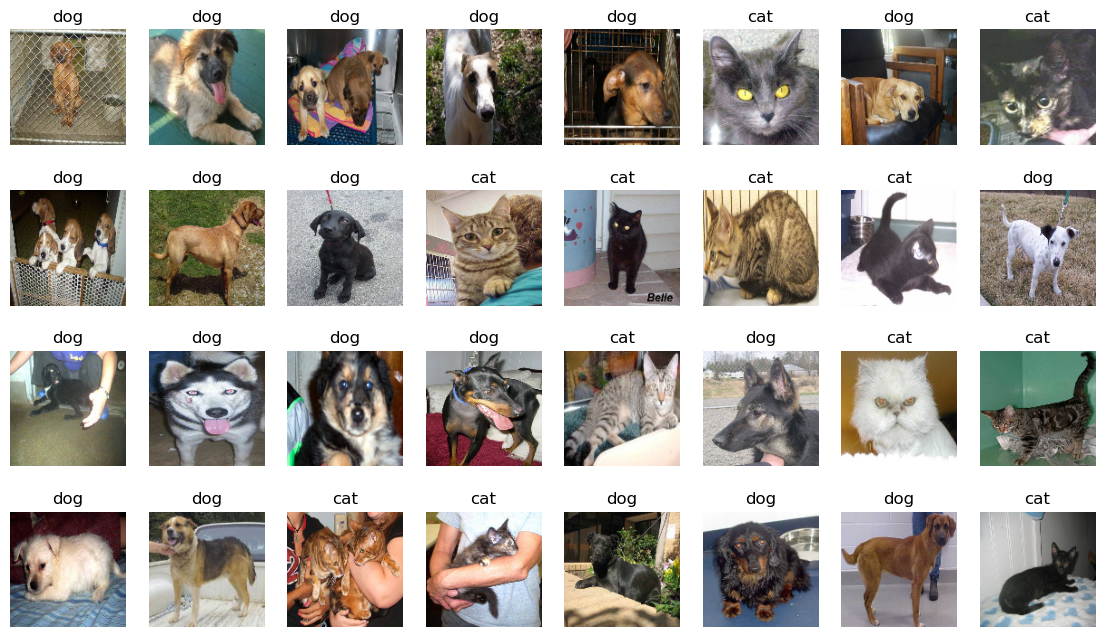

In [5]:
images = 1/255 * images    # scale to range [0, 1]

rows = 4
cols = 8

fig, axs = plt.subplots(4, 8, figsize=(14,8))

for r in range(0, rows):
    for c in range(0, cols):
        idx = r * cols + c
        axs[r, c].imshow(images[idx, :, :, :])
        if labels[idx, 0] == 1:
            axs[r, c].set_title('cat')
        else:
            axs[r, c].set_title('dog')
        axs[r, c].axis('off')

plt.show()

## Defining the CNN

There is nothing special in defining a CNN with Keras. We simply have to use the correct layer types. We need [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/), [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) and [Dense](https://keras.io/api/layers/core_layers/dense/).

To scale the image's range to $[0, 1]$ we may use a [Rescaling layer](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/).

```{important}
Due to a bug in TensorFlow 2.9 and above training of Keras models with preprocessing layers is extremely slow. See [TensorFlow issue](https://github.com/tensorflow/tensorflow/issues/55639) for current discussion.
```

In [6]:
model = keras.models.Sequential()

model.add(keras.Input(shape=(img_size, img_size, 3)))
model.add(keras.layers.Rescaling(1/255))

model.add(keras.layers.Conv2D(16, 3, activation='relu', name='conv1'))
model.add(keras.layers.Conv2D(16, 3, activation='relu', name='conv2'))
model.add(keras.layers.MaxPooling2D(name='pool1'))
model.add(keras.layers.Conv2D(32, 3, activation='relu', name='conv3'))
model.add(keras.layers.Conv2D(32, 3, activation='relu', name='conv4'))
model.add(keras.layers.MaxPooling2D(name='pool2'))

model.add(keras.layers.Flatten( name='flatten'))

#model.add(keras.layers.Dropout(0.5, name='dropout'))
#model.add(keras.layers.Dense(10, activation='relu', kernel_regularizer='l2'))

model.add(keras.layers.Dense(10, activation='relu', name='dense1'))
model.add(keras.layers.Dense(10, activation='relu', name='dense2'))

model.add(keras.layers.Dense(2, activation='sigmoid', name='out'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 126, 126, 16)      448       
                                                                 
 conv2 (Conv2D)              (None, 124, 124, 16)      2320      
                                                                 
 pool1 (MaxPooling2D)        (None, 62, 62, 16)        0         
                                                                 
 conv3 (Conv2D)              (None, 60, 60, 32)        4640      
                                                                 
 conv4 (Conv2D)              (None, 58, 58, 32)        9248      
                                                                 
 pool2 (MaxPooling2D)        (None, 29, 29, 32)        0

Number of filters per convolutional layer is chosen from experience. As rule of thumb many small (3x3 or 5x5) filters and several convolutional layers are better than few large filters. From layer to layer number of filters may be increased as feature map sizes get smaller. Without increasing the number of filters we lose information. This could be good (if lost information is useless for the net's task) or bad (if too much is lost).

By default, convolutional layers in Keras do not zero pad inputs. Padding is controlled by the `padding` argument of `Conv2D`.

## Training

For classifications tasks log loss is a good choice. For numerical minimization we may use stochastic gradient descent or Kera's default minimizer RMSProp (a momentum method).

In [7]:
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Note that `Model.fit` does not support automatic train-validation splits if data is provided as iterator object. Thus, we have to provide a separate validation set.

In [8]:
loss = []
val_loss = []
acc = []
val_acc = []

In [9]:
history = model.fit(train_data, epochs=10, validation_data=val_data)

loss.extend(history.history['loss'])
val_loss.extend(history.history['val_loss'])
acc.extend(history.history['categorical_accuracy'])
val_acc.extend(history.history['val_categorical_accuracy'])

Epoch 1/10


2023-07-03 05:34:07.590706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-07-03 05:34:08.843518: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7e59b32570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 05:34:08.843578: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce MX130, Compute Capability 5.0
2023-07-03 05:34:08.849771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 05:34:09.009400: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 [==============================] - 68s 131ms/step - loss: 0.6774 - categorical_accuracy: 0.5473 - val_loss: 0.6027 - val_categorical_accuracy: 0.6616
Epoch 2/10
469/469 [==============================] - 60s 126ms/step - loss: 0.5719 - categorical_accuracy: 0.6987 - val_loss: 0.5256 - val_categorical_accuracy: 0.7410
Epoch 3/10
469/469 [==============================] - 60s 126ms/step - loss: 0.4951 - categorical_accuracy: 0.7602 - val_loss: 0.4864 - val_categorical_accuracy: 0.7690
Epoch 4/10
469/469 [==============================] - 60s 127ms/step - loss: 0.4416 - categorical_accuracy: 0.7971 - val_loss: 0.4803 - val_categorical_accuracy: 0.7660
Epoch 5/10
469/469 [==============================] - 60s 128ms/step - loss: 0.3980 - categorical_accuracy: 0.8213 - val_loss: 0.4730 - val_categorical_accuracy: 0.7786
Epoch 6/10
469/469 [==============================] - 60s 128ms/step - loss: 0.3507 - categorical_accuracy: 0.8469 - val_loss: 0.4731 - val_categorical_accuracy: 0.79

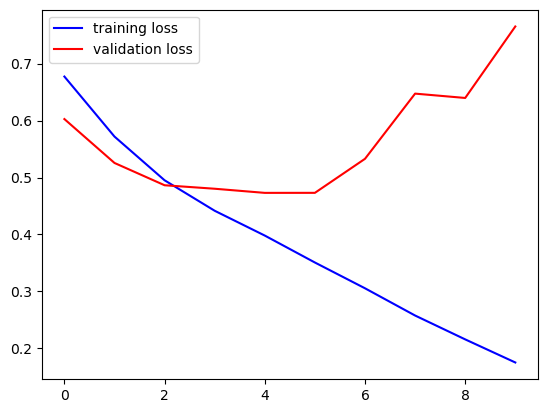

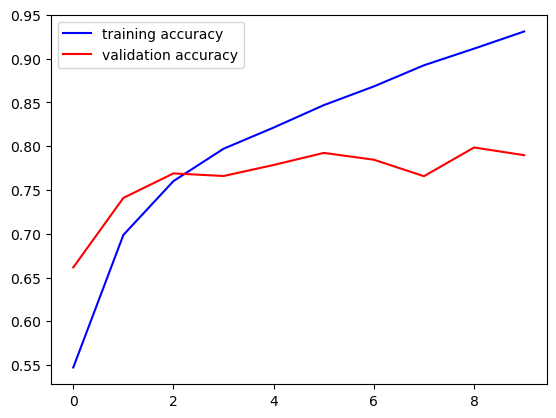

In [10]:
fig, ax = plt.subplots()
ax.plot(loss, '-b', label='training loss')
ax.plot(val_loss, '-r', label='validation loss')
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(acc, '-b', label='training accuracy')
ax.plot(val_acc, '-r', label='validation accuracy')
ax.legend()
plt.show()

After 5 epochs we observe overfitting. Thus, we should add some regularization. We could use one or more [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layers. Placement in the layer stack is somewhat arbitrary. But placing them before a dense layer will have more effect because dense layers have many input weights. With dropout we deactivate a random selection of these weights in each training step.

If dropout does not prevent overfitting, more training data should be aquired or penalty based regularization techniques should be tested. How to obtain more data will be discussed later. Penalty based regularization on a layer's weights can be activatet by passing `kernel_regularizer='l2'` to the layer's constructor. See Keras' documentation for details on [penalty based regularization](https://keras.io/api/layers/regularizers/).

In [11]:
model.save('cnnmodel.keras')

INFO:tensorflow:Assets written to: cnnmodel/assets


INFO:tensorflow:Assets written to: cnnmodel/assets


In [12]:
model = keras.models.load_model('cnnmodel.keras')

## Evaluation

To evaluate model performance we look at the metrics on the test set, which was not involved in training.

In [13]:
test_loss, test_metric = model.evaluate(test_data)

157/157 [==============================] - 7s 45ms/step - loss: 0.7523 - categorical_accuracy: 0.7894


We should have a look at missclassified images to get an idea of what features might cause missclassification.

In [14]:
test_images, test_labels = next(iter(test_data))
test_pred = model.predict(test_images)

1/1 [==============================] - 0s 134ms/step


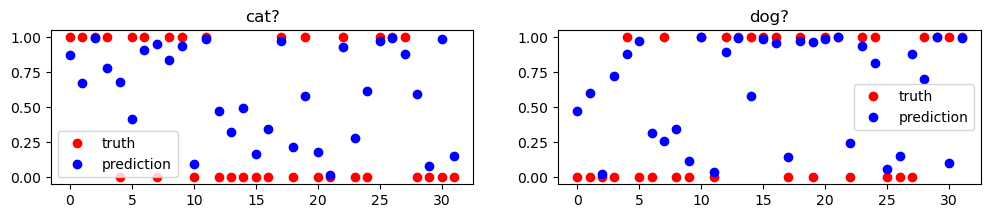

In [15]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 2))
ax1.plot(test_labels[:, 0], 'or', label='truth')
ax1.plot(test_pred[:, 0], 'ob', label='prediction')
ax1.legend()
ax1.set_title('cat?')
ax2.plot(test_labels[:, 1], 'or', label='truth')
ax2.plot(test_pred[:, 1], 'ob', label='prediction')
ax2.legend()
ax2.set_title('dog?')
plt.show()

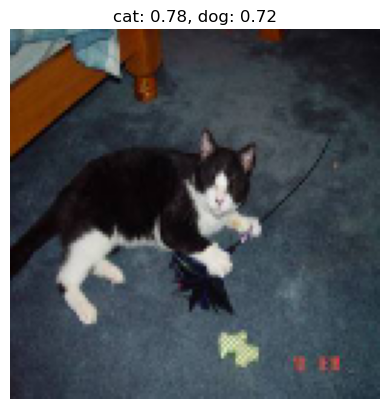

In [16]:
idx = 3

fig, ax = plt.subplots()
ax.imshow(1/255 * test_images[idx, :, :, :])
ax.set_title('cat: {:.2f}, dog: {:.2f}'.format(test_pred[idx, 0], test_pred[idx, 1]))
ax.axis('off')
plt.show()